## Link Demo
The simplest way to think of this is it's just `asyncio.gather` but it doesn't crash by handing it sync functions or values, it instead returns them after evaluating all functions, coroutines, and awaitables, in the same order like gather:

In [3]:
import ayutil as ayo
import asyncio as aio
import time as tm
async def st():
    await aio.sleep(.1)

await ayo.link(st,aio.sleep(.1),lambda : tm.sleep(.1),420)

(None, None, None, 420)

In [4]:
await aio.gather(st,aio.sleep(.1),lambda : tm.sleep(.1),420)

TypeError: An asyncio.Future, a coroutine or an awaitable is required

## Completion Funnel
This is an extension of `asyncio.as_completed`, the difference being it accepts an async generator/iterator. Then it funnels new tasks in and returns results of the latest tasks simultaneously. While as_completed in reality turns it's iterator into a set and won't begin returning results until the iterator has been walked through once. This is similar to having a future manage it's own response state but instead relegated to a FIFO generator, providing some convenience and decoupling.

In [5]:
import ayutil as ayo
import asyncio as aio
import random as rand

async def sl_random(rn=1,reself=True):
    ts=rand.random()
    await aio.sleep(ts)
    if reself:
        print(f'First Sleep Random {rn}: {ts}')
        return sl_random(rn,False)        
    else:
        print(f'Second Sleep Random {rn}: {ts}')
    
async def rn():
    for r in aio.as_completed((*(sl_random(i) for i in range(1,6)),)):
        yield await r
    
    
async for v in ayo.completion_funnel(rn(),):
    v
#completion funnel doesn't

First Sleep Random 5: 0.05457654764012776
First Sleep Random 4: 0.11663755112014795
Second Sleep Random 4: 0.06786783001674146
Second Sleep Random 5: 0.25522237389767455
First Sleep Random 2: 0.5802584186618809
First Sleep Random 1: 0.6747769889503964
First Sleep Random 3: 0.7279575081064846
Second Sleep Random 3: 0.21596820299079034
Second Sleep Random 2: 0.3773827454186065
Second Sleep Random 1: 0.606377026793165


## Waterfall Stream Scheduler

The gif generator demonstrates the dependency chain and likely scheduling path of the stream (rows) and waterfall (columns). While I was able to generate it using GPT-5 and little edits by myself, it's actually an excellent example of how existing models will always try to add more than less and eventually generate pointless code through bloated context repetition. Like a human coder sees only their present code base and not the long history of all their edits, an agentic famework should target something similar.

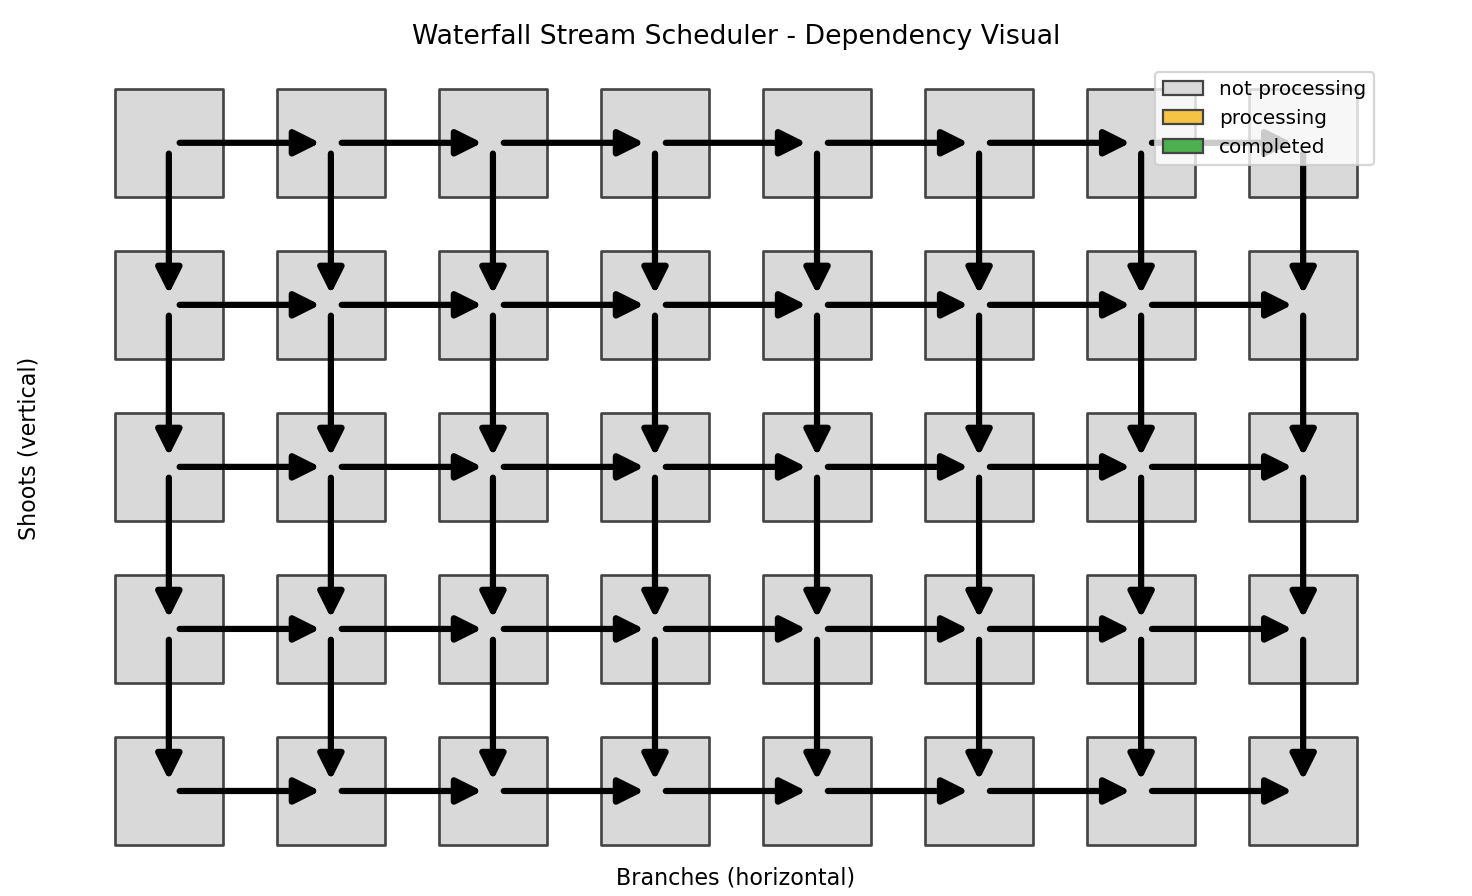

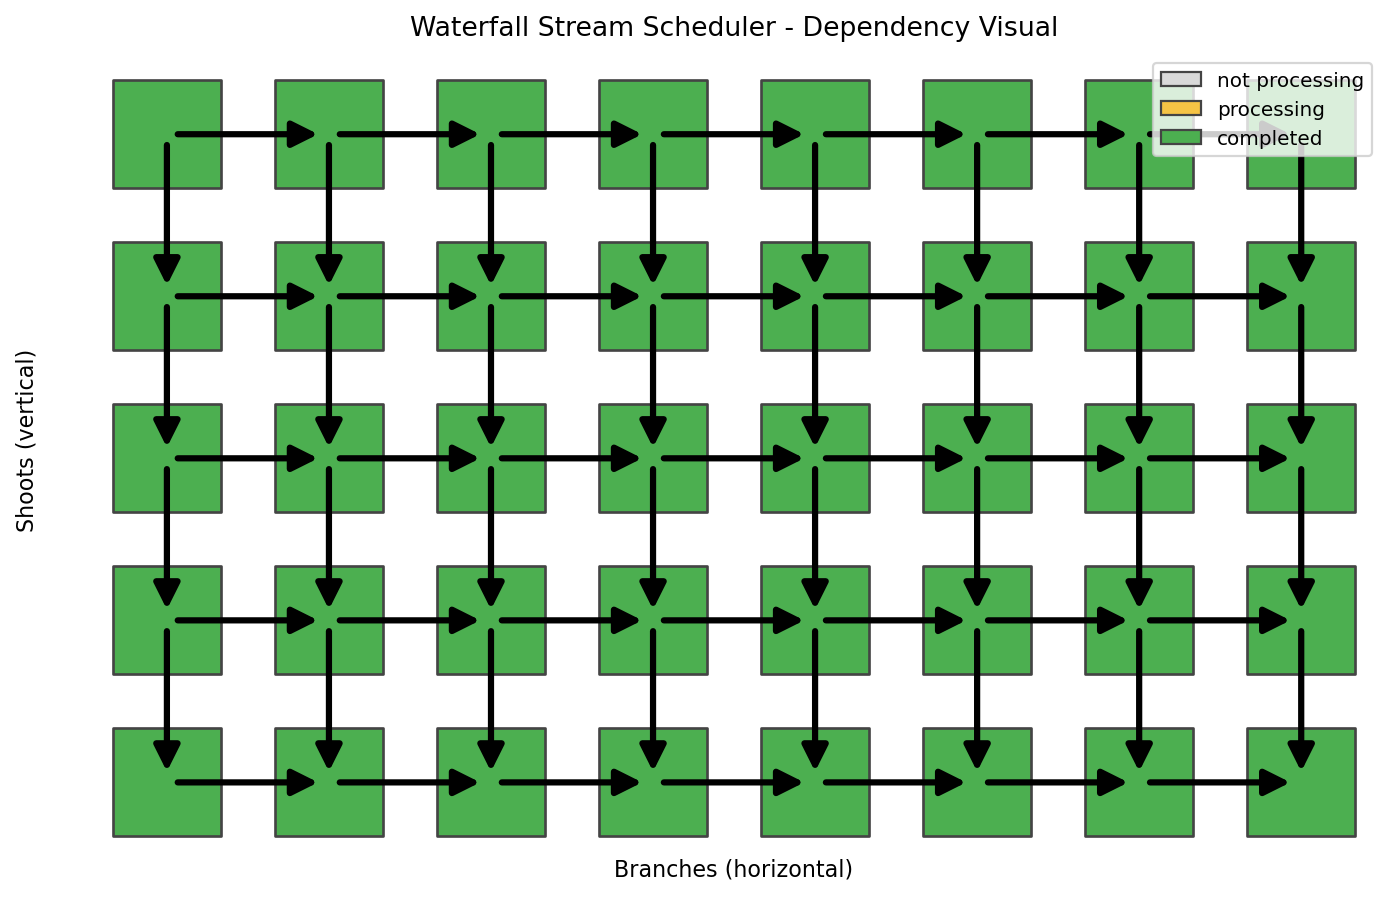

In [1]:
from typing import Optional, Sequence, Tuple

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import numpy as np
from matplotlib import animation


class PipelineGridViz:
    """
    Visualizes an m x n grid representing a pipeline of branches (→ arrows, columns)
    and shoots (↓ arrows, rows). Each cell has a state:
        0 = not processing, 1 = processing, 2 = completed

    Coordinates: row 0 is the top row on the image; column 0 is the leftmost.
    """

    DEFAULT_COLORS = {
        0: "#D9D9D9",  # not processing
        1: "#F6C445",  # processing
        2: "#4CAF50",  # completed
    }

    ARROW_COLOR_DEFAULT = "#000000"
    ARROW_COLOR_BLUE = "#1E88E5"

    def __init__(
        self,
        m: int,
        n: int,
        colors: Optional[dict] = None,
        square_size: float = 1.0,
        gap: float = 0.5,           # increased spacing to reduce corner artifacts (more spacing)
        arrow_shrink: float = 0.4,   # pull arrows farther from square edges (shorter visible arrows)
        arrow_linewidth: float = 2.8, # thicker arrow shafts
        arrow_head_scale: float = 14.0,
        head_length: float = 12.0,
        head_width: float = 8.0,
        tail_width: float = 2.0,
    ):
        if m <= 0 or n <= 0:
            raise ValueError("m and n must be positive integers")
        self.m = m
        self.n = n
        self.colors = {**self.DEFAULT_COLORS, **(colors or {})}
        self.square_size = float(square_size)
        self.gap = float(gap)
        self.arrow_shrink = float(arrow_shrink)  # in data units
        self.arrow_linewidth = float(arrow_linewidth)
        self.arrow_head_scale = float(arrow_head_scale)
        self.head_length = float(head_length)
        self.head_width = float(head_width)
        self.tail_width = float(tail_width)

        # runtime patch references for incremental updates
        self._fig = None
        self._ax = None
        self._squares: List[List[Rectangle]] = []
        self._right_arrows: List[List[Optional[FancyArrowPatch]]] = []
        self._right_arrow_colors: List[List[str]] = []
        self._down_arrows: List[List[Optional[FancyArrowPatch]]] = []
        self._down_arrow_colors: List[List[str]] = []

    # ---------------------------- helpers ---------------------------- #
    def _cell_xy(self, r: int, c: int) -> Tuple[float, float]:
        """Bottom-left (x, y) location for the given cell.
        r is row (0..m-1 from top), c is column (0..n-1 from left).
        We keep (0,0) at bottom-left in the plotting space, so we invert r.
        """
        # invert r so row 0 is visually at the top
        inv_r = (self.m - 1) - r
        x = c * (self.square_size + self.gap)
        y = inv_r * (self.square_size + self.gap)
        return x, y

    def _add_square(self, ax, r: int, c: int, state: int) -> Rectangle:
        x, y = self._cell_xy(r, c)
        rect = Rectangle(
            (x, y),
            width=self.square_size,
            height=self.square_size,
            facecolor=self.colors.get(state, self.colors[0]),
            edgecolor="#444444",
            linewidth=1.2,
            joinstyle="round",  # softer corners; reduces corner illusions
            zorder=1,
        )
        ax.add_patch(rect)
        return rect

    def _add_right_arrow(self, ax, r: int, c: int, color: str) -> Optional[FancyArrowPatch]:
        """Arrow from cell (r,c) → (r,c+1)."""
        if c >= self.n - 1:
            return None
        x0, y0 = self._cell_xy(r, c)
        x1, y1 = self._cell_xy(r, c + 1)

        sx = x0 + self.square_size - self.arrow_shrink
        sy = y0 + self.square_size / 2.0
        tx = x1 + self.arrow_shrink
        ty = y1 + self.square_size / 2.0

        arr = FancyArrowPatch(
            (sx, sy),
            (tx, ty),
            arrowstyle='-|>',
            mutation_scale=24.0,
            linewidth=self.arrow_linewidth,
            edgecolor=color,
            facecolor=color,
            zorder=5,
            shrinkA=0,
            shrinkB=0,
            capstyle='round',
        )
        ax.add_patch(arr)
        return arr

    def _add_down_arrow(self, ax, r: int, c: int, color: str) -> Optional[FancyArrowPatch]:
        """Arrow from cell (r,c) ↓ (r+1,c)."""
        if r >= self.m - 1:
            return None
        x0, y0 = self._cell_xy(r, c)
        x1, y1 = self._cell_xy(r + 1, c)

        sx = x0 + self.square_size / 2.0
        sy = y0 + self.arrow_shrink
        tx = x1 + self.square_size / 2.0
        ty = y1 + self.square_size - self.arrow_shrink

        arr = FancyArrowPatch(
            (sx, sy),
            (tx, ty),
            arrowstyle='-|>',
            mutation_scale=24.0,
            linewidth=self.arrow_linewidth,
            edgecolor=color,
            facecolor=color,
            zorder=5,
            shrinkA=0,
            shrinkB=0,
            capstyle='round',
        )
        ax.add_patch(arr)
        return arr

    # ---------------------------- public API ---------------------------- #
    def build(
        self,
        state: Optional[Sequence[Sequence[int]]] = None,
        title: Optional[str] = None,
        show_legend: bool = True,
        dpi: int = 160,
    ):
        """Create a figure with persistent patches you can update incrementally."""
        # default state = all zeros
        if state is None:
            state = [[0 for _ in range(self.n)] for _ in range(self.m)]
        if len(state) != self.m or any(len(row) != self.n for row in state):
            raise ValueError("state must be an m x n 2D sequence of ints {0,1,2}")

        total_w = self.n * self.square_size + (self.n - 1) * self.gap
        total_h = self.m * self.square_size + (self.m - 1) * self.gap
        fscale = 0.8
        fig_w = max(2.5, fscale * total_w)
        fig_h = max(2.5, fscale * total_h)

        self._fig, self._ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
        self._fig.text(
            0.5, 0.02,
            "Branches (horizontal)",
            ha="center", va="center"
        )
        self._fig.text(
            0.02, 0.5,
            "Shoots (vertical)",
            ha="center", va="center",
            rotation="vertical"
        )
        ax = self._ax
        ax.set_aspect('equal')
        ax.set_xlim(-0.25, total_w + 0.25)
        ax.set_ylim(-0.25, total_h + 0.25)
        ax.axis('off')
        ax.set_facecolor('white')

        # squares
        self._squares = [[None for _ in range(self.n)] for _ in range(self.m)]
        for r in range(self.m):
            for c in range(self.n):
                self._squares[r][c] = self._add_square(ax, r, c, int(state[r][c]))

        # arrows
        self._right_arrows = [[None for _ in range(self.n)] for _ in range(self.m)]
        self._down_arrows = [[None for _ in range(self.n)] for _ in range(self.m)]
        self._right_arrow_colors = [[self.ARROW_COLOR_DEFAULT for _ in range(self.n)] for _ in range(self.m)]
        self._down_arrow_colors = [[self.ARROW_COLOR_DEFAULT for _ in range(self.n)] for _ in range(self.m)]
        for r in range(self.m):
            for c in range(self.n):
                self._right_arrows[r][c] = self._add_right_arrow(ax, r, c, self._right_arrow_colors[r][c])
                self._down_arrows[r][c] = self._add_down_arrow(ax, r, c, self._down_arrow_colors[r][c])

        if title:
            ax.set_title(title, fontsize=12, pad=8)

        if show_legend:
            handles = [
                Rectangle((0, 0), 1, 1, facecolor=self.colors[0], edgecolor="#444444"),
                Rectangle((0, 0), 1, 1, facecolor=self.colors[1], edgecolor="#444444"),
                Rectangle((0, 0), 1, 1, facecolor=self.colors[2], edgecolor="#444444"),
            ]
            labels = ["not processing", "processing", "completed"]
            ax.legend(handles, labels, loc='upper right', frameon=True, fontsize=9)

        self._fig.tight_layout()
        return self._fig, self._ax

    def update(
        self,
        state: Optional[Sequence[Sequence[int]]] = None,
        right_arrow_colors: Optional[Sequence[Sequence[str]]] = None,
        down_arrow_colors: Optional[Sequence[Sequence[str]]] = None,
        refresh_canvas: bool = True,
    ):
        """
        Incrementally update visuals.

        - state: m x n ints in {0,1,2}
        - right_arrow_colors: m x n entries ('black'/'blue'/truthy) for → edges (ignored at last column)
        - down_arrow_colors: m x n entries ('black'/'blue'/truthy) for ↓ edges (ignored at last row)
        """
        if self._fig is None or self._ax is None:
            raise RuntimeError("Call build() first before update().")

        if state is not None:
            if len(state) != self.m or any(len(row) != self.n for row in state):
                raise ValueError("state must be an m x n 2D sequence of ints {0,1,2}")
            for r in range(self.m):
                for c in range(self.n):
                    rect = self._squares[r][c]
                    rect.set_facecolor(self.colors.get(int(state[r][c]), self.colors[0]))

        def _norm_color(val):
            # Accept logical names, booleans, or resolved hex codes from animation
            if isinstance(val, str):
                v = val.strip().lower()
                if v in ('blue', 'b') or v == self.ARROW_COLOR_BLUE.lower():
                    return 'blue'
                if v in ('black', 'k') or v == self.ARROW_COLOR_DEFAULT.lower():
                    return 'black'
                if v.startswith('#'):
                    # treat any non-default hex as blue-ish override
                    return 'blue' if v != self.ARROW_COLOR_DEFAULT.lower() else 'black'
                return 'black'
            return 'blue' if bool(val) else 'black'

        def _apply_arrow_colors(table, patches, store):
            for r in range(self.m):
                for c in range(self.n):
                    patch = patches[r][c]
                    if patch is None:
                        continue
                    raw = table[r][c]
                    col = _norm_color(raw)
                    rgba = self.ARROW_COLOR_BLUE if col == 'blue' else self.ARROW_COLOR_DEFAULT
                    patch.set_edgecolor(rgba)
                    patch.set_facecolor(rgba)
                    store[r][c] = rgba

        if right_arrow_colors is not None:
            if len(right_arrow_colors) != self.m or any(len(row) != self.n for row in right_arrow_colors):
                raise ValueError("right_arrow_colors must be m x n")
            _apply_arrow_colors(right_arrow_colors, self._right_arrows, self._right_arrow_colors)
        if down_arrow_colors is not None:
            if len(down_arrow_colors) != self.m or any(len(row) != self.n for row in down_arrow_colors):
                raise ValueError("down_arrow_colors must be m x n")
            _apply_arrow_colors(down_arrow_colors, self._down_arrows, self._down_arrow_colors)

        if refresh_canvas:
            self._fig.canvas.draw_idle()
            self._fig.canvas.flush_events()
        return self._fig, self._ax
    
    def draw(
        self,
        state: Optional[Sequence[Sequence[int]]] = None,
        title: Optional[str] = None,
        show_legend: bool = True,
        dpi: int = 160,
        save_path: Optional[str] = None,
    ):
        """
        Convenience: build a fresh figure and optionally save to file.
        """
        fig, ax = self.build(state=state, title=title, show_legend=show_legend, dpi=dpi)
        if save_path:
            fig.savefig(save_path, bbox_inches='tight')
        return fig, ax

    def _snapshot_rgb(self) -> np.ndarray:
        """Return an RGB numpy array of the current figure."""
        if self._fig is None:
            raise RuntimeError("Build or draw before snapshot.")
        canvas = self._fig.canvas
        canvas.draw()  # ensure up-to-date
        w, h = canvas.get_width_height()
        buf = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
        return buf.reshape((h, w, 3))

    def render_gif(
        self,
        changes_per_frame: Sequence[Sequence[dict]],
        base_state: Optional[Sequence[Sequence[int]]] = None,
        title: Optional[str] = None,
        show_legend: bool = True,
        dpi: int = 160,
        duration: float = 1.0,
        save_path: str = "grid_anim.gif",
        include_initial_frame: bool = True,
    ) -> str:
      
        """
        Build frames by applying per-frame changes and export an animated GIF using
        matplotlib's Pillow writer (no imageio dependency).

        Parameters
        ----------
        changes_per_frame : sequence where each element is a 3-item sequence of dicts:
            [cell_changes, right_arrow_changes, down_arrow_changes]
            - cell_changes: {(i, j): value} with value in {0,1,2} or a delta int.
            - right_arrow_changes: {(i, j): 'blue'|'black'|truthy} for → (i,j)->(i,j+1).
            - down_arrow_changes: {(i, j): 'blue'|'black'|truthy} for ↓ (i,j)->(i+1,j).
            Colors default to black when unspecified.
        include_initial_frame : if True, a no-op frame is prefixed so the
            initial state is visible as the first frame.
        """
        # Initialize state
        if base_state is None:
            state = [[0 for _ in range(self.n)] for _ in range(self.m)]
        else:
            if len(base_state) != self.m or any(len(row) != self.n for row in base_state):
                raise ValueError("base_state must be m x n")
            state = [list(map(int, row)) for row in base_state]

        # Build fresh figure
        self.build(state=state, title=title, show_legend=show_legend, dpi=dpi)

        # Prepare sequence of frame change dicts
        frames_changes: List[Tuple[dict, dict, dict]] = []
        if include_initial_frame:
            frames_changes.append(({}, {}, {}))  # no-op first frame
        for f in changes_per_frame:
            # Back-compat: allow a single dict (old API) to mean only cell changes
            if isinstance(f, dict):
                frames_changes.append((f, {}, {}))
                continue
            cell = f[0] if len(f) > 0 else {}
            right = f[1] if len(f) > 1 else {}
            down = f[2] if len(f) > 2 else {}
            frames_changes.append((cell, right, down))

        # Apply one frame of changes
        def _apply_changes(frame_idx: int):
            cell_changes, right_changes, down_changes = frames_changes[frame_idx]
            # apply cell updates
            if cell_changes:
                for (i, j), val in cell_changes.items():
                    if not (0 <= i < self.m and 0 <= j < self.n):
                        continue
                    cur = int(state[i][j])
                    if isinstance(val, (int, np.integer)) and val in (0, 1, 2):
                        newv = int(val)
                    else:
                        newv = int(max(0, min(2, cur + int(val))))
                    state[i][j] = newv
            # apply arrow color updates
            def _apply_arrow_dict(changes, color_table):
                if not changes:
                    return
                for (i, j), col in changes.items():
                    if not (0 <= i < self.m and 0 <= j < self.n):
                        continue
                    # robust normalization: only 'blue' (or truthy) maps to blue; 'black' is black
                    is_blue = False
                    if isinstance(col, str):
                        s = col.strip().lower()
                        if s in ('blue', '#1e88e5', 'b'):
                            is_blue = True
                        elif s in ('black', '#000000', 'k'):
                            is_blue = False
                        else:
                            is_blue = bool(col)
                    else:
                        is_blue = bool(col)
                    color_table[i][j] = self.ARROW_COLOR_BLUE if is_blue else self.ARROW_COLOR_DEFAULT
            _apply_arrow_dict(right_changes, self._right_arrow_colors)
            _apply_arrow_dict(down_changes, self._down_arrow_colors)

            # push updates to artists in one call
            self.update(
                state=state,
                right_arrow_colors=self._right_arrow_colors,
                down_arrow_colors=self._down_arrow_colors,
                refresh_canvas=False,
            )
            return []

        anim = animation.FuncAnimation(
            self._fig,
            func=_apply_changes,
            frames=len(frames_changes),
            interval=duration * 1000.0,
            blit=False,
            repeat=False,
        )

        fps = max(1, int(round(1.0 / max(duration, 1e-6))))
        writer = animation.PillowWriter(fps=fps)
        anim.save(save_path, writer=writer)
        return save_path


def build_breadth_first_frames(v: PipelineGridViz):
    """Final animation per spec with *one change per branch per frame*,
    branch 0 = top row, breadth-first across columns, and correct tail-off
    on the last column. Additionally enforces a frontier rule so you never
    see two blue arrows in a row/column: per row there is at most one blue
    → (the rightmost non-grey → grey), and per column at most one blue ↓
    (the lowest non-grey → grey). """
    m, n = v.m, v.n
    frames: list[tuple[dict, dict, dict]] = []

    # Local state grid to drive arrow persistence
    state = [[0 for _ in range(n)] for _ in range(m)]

    # Current blue sets
    blue_right: set[tuple[int, int]] = set()
    blue_down: set[tuple[int, int]] = set()

    def recompute_frontier():
        """Return (right_set, down_set) enforcing one blue per row/column frontier."""
        rset = set()
        dset = set()
        # per row: pick the largest j with state[i][j] != 0 and state[i][j+1] == 0
        for i in range(m):
            best = None
            for j in range(n - 1):
                if state[i][j] != 0 and state[i][j + 1] == 0:
                    best = j if (best is None or j > best) else best
            if best is not None:
                rset.add((i, best))
        # per column: pick the largest i with state[i][j] != 0 and state[i+1][j] == 0
        for j in range(n):
            best = None
            for i in range(m - 1):
                if state[i][j] != 0 and state[i + 1][j] == 0:
                    best = i if (best is None or i > best) else best
            if best is not None:
                dset.add((best, j))
        return rset, dset

    def diff_colors(new_right, new_down):
        rights, downs = {}, {}
        # turn off ones no longer on the frontier
        for idx in (blue_right - new_right):
            rights[idx] = 'black'
        for idx in (blue_down - new_down):
            downs[idx] = 'black'
        # turn on newly added frontier arrows
        for idx in (new_right - blue_right):
            rights[idx] = 'blue'
        for idx in (new_down - blue_down):
            downs[idx] = 'blue'
        return rights, downs

    # Frame 2: entire first branch (row 0) processing
    cells = {(0, c): 1 for c in range(n)}
    for c in range(n):
        state[0][c] = 1
    new_r, new_d = recompute_frontier()
    rights, downs = diff_colors(new_r, new_d)
    blue_right, blue_down = new_r, new_d
    frames.append((cells, rights, downs))

    # Frame 3: first branch completed; start (1,0)
    cells = {(0, c): 2 for c in range(n)}
    for c in range(n):
        state[0][c] = 2
    if m > 1:
        cells[(1, 0)] = 1
        state[1][0] = 1
    new_r, new_d = recompute_frontier()
    rights, downs = diff_colors(new_r, new_d)
    blue_right, blue_down = new_r, new_d
    frames.append((cells, rights, downs))

    # Simulate breadth-first with per-row pointers
    pos = [None] * m
    started = [False] * m
    finished = [False] * m
    if m > 1:
        pos[1] = 0; started[1] = True
    t = 0

    def any_active():
        return any(started[i] and not finished[i] for i in range(1, m))

    def should_start_row(i, t):
        return (not started[i]) and (t >= (i - 1))

    while True:
        t += 1
        cells = {}

        # Start new rows when due
        for i in range(2, m):
            if should_start_row(i, t) and not finished[i]:
                pos[i] = 0
                started[i] = True
                cells[(i, 0)] = 1
                state[i][0] = 1

        # Advance each active row by one
        for i in range(1, m):
            if not started[i] or finished[i]:
                continue
            j = pos[i]
            if j is None:
                continue
            if j < n - 1:
                cells[(i, j)] = 2
                state[i][j] = 2
                pos[i] = j + 1
                cells[(i, pos[i])] = 1
                state[i][pos[i]] = 1
            else:
                cells[(i, j)] = 2
                state[i][j] = 2
                finished[i] = True

        # Recompute frontier arrows from current state and diff against prior
        new_r, new_d = recompute_frontier()
        rights, downs = diff_colors(new_r, new_d)
        blue_right, blue_down = new_r, new_d

        if cells or rights or downs:
            frames.append((cells, rights, downs))
        if not any_active():
            break

    return frames


# ---------------------------- quick visual smoke test ---------------------------- #
if __name__ == "__main__":
    # Example grid
    m, n = 5, 8
    viz = PipelineGridViz(m=m, n=n)

    # Base state: all idle (grey)
    base = [[0 for _ in range(n)] for _ in range(m)]

    def build_breadth_first_frames(v: PipelineGridViz):
        """Final animation per spec (branch 0 is TOP ROW, shoots are COLUMNS).
        Frames are tuples: (cell_changes, right_changes, down_changes).
        Blue arrows persist from green→grey until the *target* cell becomes
        yellow/green; only then do they revert to black.
        """
        m, n = v.m, v.n
        frames: list[tuple[dict, dict, dict]] = []

        # Maintain a local state snapshot to reason about arrow persistence
        state = [[0 for _ in range(n)] for _ in range(m)]  # 0 grey,1 yellow,2 green

        # Helper to decide which previous blue arrows should revert
        def revert_blues(prev_right, prev_down):
            rights_blk, downs_blk = {}, {}
            for (i, j) in prev_right:
                # right arrow (i,j) -> (i,j+1)
                if j + 1 < n and state[i][j + 1] != 0:
                    rights_blk[(i, j)] = 'black'
            for (i, j) in prev_down:
                # down arrow (i,j) -> (i+1,j)
                if i + 1 < m and state[i + 1][j] != 0:
                    downs_blk[(i, j)] = 'black'
            return rights_blk, downs_blk

        # Track current blue sets
        blue_right: set[tuple[int, int]] = set()
        blue_down: set[tuple[int, int]] = set()
        
        pending_edge: set[tuple[int, int]] = set()

        # ---- Frame 2: entire first branch (row 0) processing; all downs under row 0 blue ----
        cells = {(0, c): 1 for c in range(n)}
        for c in range(n):
            state[0][c] = 1
        rights: dict = {}
        downs = {(0, c): 'blue' for c in range(n) if m > 1}
        if m > 1:
            blue_down |= {(0, c) for c in range(n)}
        frames.append((cells, rights, downs))

        # ---- Frame 3: first branch completed; start branch 1 at (1,0) ----
        cells = {(0, c): 2 for c in range(n)}
        for c in range(n):
            state[0][c] = 2
        if m > 1:
            cells[(1, 0)] = 1
            state[1][0] = 1
        # Revert only those blue downs whose targets turned non-grey this frame
        r_blk, d_blk = revert_blues(set(), blue_down)
        rights = r_blk
        downs = d_blk
        # New blues from active cell (1,0): right and down if exist
        if m > 1 and n > 1:
            rights[(1, 0)] = 'blue'
            blue_right = {(1, 0)}
        if m > 2:
            downs[(1, 0)] = 'blue'
            blue_down = (blue_down - set(d_blk.keys())) | {(1, 0)}
        else:
            blue_down = (blue_down - set(d_blk.keys()))
        frames.append((cells, rights, downs))

    # ---- Breadth-first diagonal wave for rows i>=1 ----
        max_k = (m - 1) + (n - 1)
        for k in range(2, max_k + 1):
            cells = {}
    
            # NEW: first, promote last-frame edge yellows to green
            if pending_edge:
                for (pi, pj) in pending_edge:
                    cells[(pi, pj)] = 2
                    state[pi][pj] = 2
                pending_edge = set()  # cleared for this frame
    
            active_positions = []
            for i in range(1, m):
                j = k - i
                if 0 <= j < n:
                    if j - 1 >= 0:
                        cells[(i, j - 1)] = 2
                        state[i][j - 1] = 2
    
                    # NEW: always show yellow on the last column first,
                    # then schedule it to turn green on the NEXT frame
                    cells[(i, j)] = 1
                    state[i][j] = 1
                    active_positions.append((i, j))
    
            # revert blues whose targets turned non-grey this frame
            r_blk, d_blk = revert_blues(blue_right, blue_down)
            rights = r_blk
            downs = d_blk
    
            new_right = set()
            new_down = set()
    
            # NEW: collect edge yellows to promote next frame
            promote_next = set()
    
            for (ii, jj) in active_positions:
                if jj < n - 1:
                    rights[(ii, jj)] = 'blue'
                    new_right.add((ii, jj))
                else:
                    # last column: schedule promotion next frame (no right arrow)
                    promote_next.add((ii, jj))
                if ii < m - 1:
                    downs[(ii, jj)] = 'blue'
                    new_down.add((ii, jj))
    
            blue_right = (blue_right - set(r_blk.keys())) | new_right
            blue_down  = (blue_down  - set(d_blk.keys())) | new_down
    
            # NEW: set pending promotions for the next iteration
            pending_edge |= promote_next
    
            frames.append((cells, rights, downs))
    
        # ---- Final cleanup: if any edge yellows remain, promote them in their own frame ----
        if pending_edge:
            cells = {}
            for (pi, pj) in pending_edge:
                cells[(pi, pj)] = 2
                state[pi][pj] = 2
            r_blk, d_blk = revert_blues(blue_right, blue_down)
            frames.append((cells, r_blk, d_blk))
            pending_edge = set()
    
        # Keep your original safety-net cleanup (no-op now, but harmless)
        cells = {}
        for i in range(1, m):
            if n > 0:
                cells[(i, n - 1)] = 2
                state[i][n - 1] = 2
        r_blk, d_blk = revert_blues(blue_right, blue_down)
        frames.append((cells, r_blk, d_blk))
    
        return frames


    # Build BFS frames and render GIF. The first frame (all grey/black) is included by the renderer.
    frames = build_breadth_first_frames(viz)
    gif_path = viz.render_gif(
        changes_per_frame=frames,
        base_state=base,
        duration=.5,
        save_path="grid_anim.gif",
        title="Waterfall Stream Scheduler - Dependency Visual",
        include_initial_frame=True,
    )

from IPython.display import Image

Image(filename="grid_anim.gif")


The only dependency of this scheduler is that at a given yellow square along row i and column j, must have results returned for all $0$ to $i - 1$ rows and $0$ to $j$ columns. Note that tasks from the same row $i$ do **not** have to be processed first, this is somewhat demonstrated by the first row finishing simultaneously. This allows stream tasks to finish at unordered times but still provide ordered results, it's only this grid dependency that needs to be satisfied before the task is scheduled. The animation demonstrates a strict breadth first search starting at square/node (1,0), in a real setting all of row 1 may be scheduled (turn yellow) nearly simultaneously, corresponding with availability. This means that depending on how much concurrency and compute division is available, you will achieve the most throughput by sorting the processing stages from least to most time and assign them descending to each row.

### How to use:

In [1]:
from ayutil import shoot_next,make_brancheshoot
import asyncio as aio
import time as tm
import random as rand

branches, shoots = make_brancheshoot(4, 4)
#shoots=queues
branches, shoots

([<async_generator object _shoot_yield at 0x0000022A48187DE0>,
  <async_generator object _shoot_yield at 0x0000022A4830CBF0>,
  <async_generator object _shoot_yield at 0x0000022A4830CD00>,
  <async_generator object _shoot_yield at 0x0000022A4830CE10>],
 [<Queue at 0x22a47f73a10 maxsize=0>,
  <Queue at 0x22a47f731d0 maxsize=0>,
  <Queue at 0x22a47f73510 maxsize=0>,
  <Queue at 0x22a47f71e90 maxsize=0>])

In [2]:
branches, shoots = make_brancheshoot(4, 4)

fc=1/len(shoots)

async def sleepnr(sl):
    ts=rand.random() if sl ==0. else sl
    await aio.sleep(ts)
    return ts
#sleepnr can represent any kind mini-batch processing framework such as (but no limited to):
#  Multi-core or multi-gpu contiguous memory or vector processing.
#  Improving the efficiency of LLM responses that require this context ordering.

async def gen_passthrough(ayiter:aiter, corofunc, branch=1, itime=0, verbose=True, nopass=False):
    br=1
    async for dly,q in ayiter:
        if not nopass:
            shoot_next(corofunc(0.),q)
        if verbose:print(f'Branch: {branch}, Shoot: {br}, Full Delay: {(tm.perf_counter() - itime):.5f}, Required Delay: {dly}')
        br+=1
#Depending on if you implement a generic gen_passthrough or separate ones for each depth layer
#You can also implement logic or delays within the iterator.

#sleep line 1, no dependencies but variable sleep delay for example. start
st=tm.perf_counter()

#sleepinit=aio.gather(*(shoot_next(sleepnr(0.),q) for q in shoots),)

(*(shoot_next(sleepnr(.01+i/3),q) for i,q in enumerate(shoots)),) #no need to await this one
sleep1=gen_passthrough(branches[0], sleepnr, 1, st, )
sleep2=gen_passthrough(branches[1], sleepnr, 2, st, )
sleep3=gen_passthrough(branches[2], sleepnr, 3, st, )
sleep4=gen_passthrough(branches[3], sleepnr, 4, st, nopass=True)
sleep1,sleep2,sleep3,sleep4=tuple(aio.ensure_future(sl) for sl in (sleep1,sleep2,sleep3,sleep4))
await sleep1
print(f"--- Round 1 Sleep completed in {tm.perf_counter()-st:.5f} seconds.")
await sleep2
print(f"--- Round 2 Sleep completed in {tm.perf_counter()-st:.5f} seconds.")
await sleep3
print(f"--- Round 3 Sleep completed in {tm.perf_counter()-st:.5f} seconds.")
await sleep4
print(f"--- Round 4 Sleep completed in {tm.perf_counter()-st:.5f} seconds.")

Branch: 1, Shoot: 1, Full Delay: 0.01079, Required Delay: 0.01
Branch: 1, Shoot: 2, Full Delay: 0.33944, Required Delay: 0.3433333333333333
Branch: 2, Shoot: 1, Full Delay: 0.50218, Required Delay: 0.48981525992534747
Branch: 1, Shoot: 3, Full Delay: 0.67899, Required Delay: 0.6766666666666666
Branch: 1, Shoot: 4, Full Delay: 1.00246, Required Delay: 1.01
--- Round 1 Sleep completed in 1.00263 seconds.
Branch: 2, Shoot: 2, Full Delay: 1.25162, Required Delay: 0.9019792900760184
Branch: 2, Shoot: 3, Full Delay: 1.25169, Required Delay: 0.45561214875046663
Branch: 3, Shoot: 1, Full Delay: 1.25170, Required Delay: 0.7458772693424176
Branch: 3, Shoot: 2, Full Delay: 1.29471, Required Delay: 0.04268964480624271
Branch: 4, Shoot: 1, Full Delay: 1.31919, Required Delay: 0.07024395102732661
Branch: 4, Shoot: 2, Full Delay: 1.86016, Required Delay: 0.5562501735501559
Branch: 2, Shoot: 4, Full Delay: 1.86023, Required Delay: 0.8639269307555185
--- Round 2 Sleep completed in 1.86035 seconds.
Bran

We see that the 2D dependency grid is satisfied.

### Provider Decorator for Static Dict - Demo

In [1]:
from typing import List, Optional, Tuple, Collection
from ayutil.generics import provider_factory,ProviderSpec

#A global dict, we want the args of the dict to be the same, but don't care if it's modifiable
g_dict={1:'h',2:'l',5:'test'}

#multiple strategies
# 1.
class ProvideDict(ProviderSpec):
    #we use instance instead of class methods and parameters, for easier genericity.
    def call(self): return g_dict.copy() # as it shouldn't modify we dont need: global g_dict
    
Ps1=ProvideDict() #optional: provider_type=dict,provider_kwargs=('dic','dic1')
# 2.
Ps2=ProviderSpec(g_dict.copy(),provider_kwargs=('dic1','dic'))

d_prov1=provider_factory(Ps1,kwarg_names=('dic1','dic'))
d_prov2=provider_factory(Ps2)

#@d_prov1
def test_modify1(somt,somt1=5,dic1:dict=None):
    print(f'Test 1,{somt} dict before:',dic1)
    dic1[somt1]=somt
    print(f'Test 1,{somt} dict after:',dic1)

test_m1p1=d_prov1(test_modify1)
test_m1p2=d_prov2(test_modify1)

print('Calling decorated dict modification:')
test_m1p1(1,)
test_m1p2(2,)
print('global dict:',g_dict)
print('\nCalling test_m1p2 a second time:')
test_m1p2(3,)
print('global dict:',g_dict)

print('\nWithout decorators:')
def test_b(somt,somt1=5,dic1:dict=g_dict):
    print(f'Test b,{somt} dict before:',dic1)
    dic1[somt1]=somt
    print(f'Test b,{somt} dict after:',dic1)
test_b(1)
test_b(2)
print('global dict:',g_dict)


#Now if we want to change the object instance of global dict?
def chg_forp1():
    global g_dict
    g_dict={1:'l',2:'l',5:'test'} #all that is needed for our override class
    #note how we don't need to reference the provider instance.
    #if our type is not the same, eg we turn it into another collection, need to call:
    del Ps1.provider_type

def chg_forp2():
    global g_dict
    g_dict={1:'l',2:'l',5:'test'}
    Ps2.new_instance(g_dict.copy())
    #the difference between the first and second method boils down to a static reference or per object ref.
    
chg_forp1()
chg_forp2()
print('\nAfter Reset:')
test_m1p2(2,)
print('global dict:',g_dict)

@d_prov1('dic2')
def test_m2p1(somt,somt1=5,dic2:dict=None):
    print(f'Test 2,{somt} dict before:',dic2)
    dic2[somt1]=somt
    print(f'Test 2,{somt} dict after:',dic2)

print('\nDecorator with non-default kwarg spec:')
test_m2p1(1,)


class ProvideDict2(ProviderSpec):
    #we use instance instead of class methods and parameters, for easier genericity.
    def call(self): return g_dict.copy() # as it shouldn't modify we dont need: global g_dict
    def provider_type(self): return type(self()) #assuming it's cheap enough
    
#base class example:
class ProvideDict3(ProviderSpec):
    #we use instance instead of class methods and parameters, for easier genericity.
    def call(self): return g_dict.copy() # as it shouldn't modify we dont need: global g_dict
    def provider_type(self): return Collection

d_prov22=provider_factory(ProvideDict2(provider_kwargs=('dic1','dic')))
d_prov3=provider_factory(ProvideDict3(provider_kwargs=('dic1','dic')))

test_m1p22=d_prov22(test_modify1)
test_m1p3=d_prov3(test_modify1)

print('\nTest without type reset:')
test_m1p22(1,1)
test_m1p3(1,1)

g_dict=['h','l','test']
print('\nAfter changing collection type')
test_m1p22(1,1)
test_m1p3(1,1)
print('global list:',g_dict)



Calling decorated dict modification:
Test 1,1 dict before: {1: 'h', 2: 'l', 5: 'test'}
Test 1,1 dict after: {1: 'h', 2: 'l', 5: 1}
Test 1,2 dict before: {1: 'h', 2: 'l', 5: 'test'}
Test 1,2 dict after: {1: 'h', 2: 'l', 5: 2}
global dict: {1: 'h', 2: 'l', 5: 'test'}

Calling test_m1p2 a second time:
Test 1,3 dict before: {1: 'h', 2: 'l', 5: 2}
Test 1,3 dict after: {1: 'h', 2: 'l', 5: 3}
global dict: {1: 'h', 2: 'l', 5: 'test'}

Without decorators:
Test b,1 dict before: {1: 'h', 2: 'l', 5: 'test'}
Test b,1 dict after: {1: 'h', 2: 'l', 5: 1}
Test b,2 dict before: {1: 'h', 2: 'l', 5: 1}
Test b,2 dict after: {1: 'h', 2: 'l', 5: 2}
global dict: {1: 'h', 2: 'l', 5: 2}

After Reset:
Test 1,2 dict before: {1: 'l', 2: 'l', 5: 'test'}
Test 1,2 dict after: {1: 'l', 2: 'l', 5: 2}
global dict: {1: 'l', 2: 'l', 5: 'test'}

Decorator with non-default kwarg spec:
Test 2,1 dict before: {1: 'l', 2: 'l', 5: 'test'}
Test 2,1 dict after: {1: 'l', 2: 'l', 5: 1}

Test without type reset:
Test 1,1 dict before: